# K-means com a base boston

Disciplina: Inteligência Artificial <br/>
Instituto Federal do Norte de Minas Gerais Campus Montes Claros <br/>
Curso: Ciência da Computação <br/>
Professora: Luciana Balieiro Cosme<br/>
Desenvolvido por: Nayara Thaiza P. Soares <br/>

**Objetivo: Realizar regressão com o algoritmo k-means na base boston** <br/>

In [1]:
#importações
import numpy as np  
import pandas as pd  
import random
import math
import operator
from numpy import genfromtxt
from random import randrange
#dados
from sklearn import datasets
#plot
import matplotlib.pyplot as plt


#carrega base de dados
boston = datasets.load_boston()

#itens da base
boston.keys()

print(boston.DESCR)

dataset = pd.DataFrame(boston.data) 
dataset = dataset.astype('float64') # converte para float
dataset.columns = boston.feature_names
dataset['PRECO'] = boston.target 


# divide as características em listas
id = [] #indices
for i in range(len(dataset)):
    id.append(i)
f1 = dataset['RM'].values
f2 = dataset['AGE'].values
f3 = dataset['DIS'].values
f4 = dataset['LSTAT'].values
preco = dataset['PRECO'].values

dados_originais = np.array(list(zip(id, preco, f1, f2, f3, f4)))

#caracteristicas que irei usar no kmeans
dados = np.array(list(zip(f1, f2, f3, f4)))

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [2]:
dataset = dataset.drop('CRIM',axis=1)
dataset = dataset.drop('ZN',axis=1)
dataset = dataset.drop('INDUS',axis=1)
dataset = dataset.drop('CHAS',axis=1)
dataset = dataset.drop('NOX',axis=1)
dataset = dataset.drop('RAD',axis=1)
dataset = dataset.drop('TAX',axis=1)
dataset = dataset.drop('PTRATIO',axis=1)
dataset = dataset.drop('B',axis=1)

#quantitativo de dados
observ = len(boston.data)
carac = len(dataset.columns)
print("Numero de observações (linhas): " + str(observ))
print("Numero de caracteristicas: " + str(carac))
dataset.head(10)



Numero de observações (linhas): 506
Numero de caracteristicas: 5


,RM,AGE,DIS,LSTAT,PRECO
0,6.575,65.2,4.0900,4.98,24.0
1,6.421,78.9,4.9671,9.14,21.6
2,7.185,61.1,4.9671,4.03,34.7
3,6.998,45.8,6.0622,2.94,33.4
4,7.147,54.2,6.0622,5.33,36.2
5,6.430,58.7,6.0622,5.21,28.7
6,6.012,66.6,5.5605,12.43,22.9
7,6.172,96.1,5.9505,19.15,27.1
8,5.631,100.0,6.0821,29.93,16.5
9,6.004,85.9,6.5921,17.10,18.9


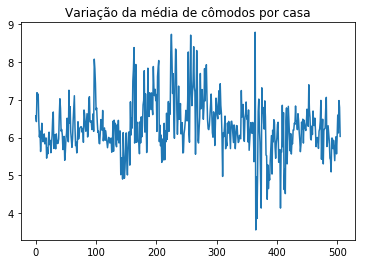

In [3]:
for var in ['RM']:
    x = dataset[var].values  
    plt.plot(x)
    plt.title('Variação da média de cômodos por casa')

plt.show()

**Função: euc_dist (distância euclidiana) e calc_dist (reorganiza os clusters de acordo com as novas distancias)** <br/>
**euc_dist:** Dados dois vetores como parametros é calculado a distância euclidiana entre eles <br/>
**calc_dist:** Em posse dos dados, e dos centros, calcula a distância euclidiana entre eles para posteriormente reorganizar os dados de acordo com seu novo centro.

In [4]:
#distancia euclidiana
def euc_dist(a, b):
    sum = 0
    for i, j in zip(a, b):
        a = (i - j) * (i - j)
        sum = sum + a
    return math.sqrt(sum)

#calcula distancia entre dados e o centro
def calc_dist(centros, dados):
    c_dist = []
    for i in centros:
        temp = []
        for j in dados:
            temp.append(euc_dist(i, j))
        c_dist.append(temp)
    return c_dist


**Função: centros_iniciais (define os centros iniciais dos clusters) e atualiza_centros (define os novos centros baseados nos vetores de clusters)** <br/>
**centros_iniciais**: Inicialmente os k centros são definidos randomicamente dentro do conjunto de dados e de acordo com a quantidade de caracteristicas selecionadas. <br/>
O parâmetro k é a quantidade de clusters, visto que cada cluster tem um centro.<br/>
**separa_clusters:** Em posse do numero de clusters (ou centros), e da tabela de distancia obtida na função calc_dist, reorgniza os clusters de acordo com as novas distâncias dos centros obtidas  <br/>
**atualiza_centros:** atualiza os centros, recalculando depois que os clusters foram re-organizados <br/>


In [5]:
#define os centros iniciais por meio de uma função randomica
def centros_iniciais(k, dados):
    c = []
    s = np.random.randint(low=1, high=len(dados), size=k)
    while (len(s) != len(set(s))):
        s = np.random.randint(low=1, high=len(dados), size=k)
    for i in s:
        c.append(dados[i])
    return c

#guarda a posicao de cada index do dataset separado por cluster
def separa_cluster(k, dist_table):
    clusters = []
    for i in range(k):
        clusters.append([])
    for i in range(len(dist_table[0])):
        d = []
        for j in range(len(dist_table)):
            d.append(dist_table[j][i])
        clusters[d.index(min(d))].append(i)
    return clusters

def atualiza_centros(centros, tab_cluster, dados):
    for i in range(len(centros)):
        if (len(tab_cluster[i]) > 0):
            temp = []
            for j in tab_cluster[i]:
                temp.append(list(dados[j]))
            sum = [0] * len(centros[i])
            for l in temp:
                sum = [(a + b) for a, b in zip(sum, l)] # compreensao de listas [expression for name in list]
            centros[i] = [p / len(temp) for p in sum]
    return centros



**Aplicando o kMeans (chamando as outras funções e expondo resultados)** <br/>
O iter é a quantidade de iterações, quanto mais iterações melhor, mas a partir de um certo número de iterações, os resultados não mudam. <br/>
Os membros dos clusters estão ordenado em: posição, preço, RM (número de comodos), AGE (idade), DIS (distância do centro) e	LSTAT (condição socioeconômica).

In [6]:
#Chama função com num_clusters = 3 e num_iterações = 10
k = 3
iter = 50
  
dist_mem = []
cluster_mem = []
membros = []

#inicializa os centros
centros = centros_iniciais(k, dados)
#calcula a distancia entre centro e dataset
tabela_distancias = calc_dist(centros, dados)
tabela_clusters = separa_cluster(k, tabela_distancias)
novos_centros = atualiza_centros(centros, tabela_clusters, dados)

for i in range(iter):
    tabela_distancias = calc_dist(novos_centros, dados)
    tabela_clusters = separa_cluster(k, tabela_distancias)
    novos_centros = atualiza_centros(novos_centros, tabela_clusters, dados)


for i in range(len(novos_centros)):
    p1 = p2 = p3 = p4 = 0
    print("Centro #", i, ": ", novos_centros[i])
    print("Membros do cluster: ")
    for j in range(len(tabela_clusters[i])):
        print(dados_originais[tabela_clusters[i][j]])
        


        #verficando os extremamente proximos
        if(dados_originais[tabela_clusters[i][j]][2] == round(novos_centros[i][0], 1)):
            p1 = p1+1;
        if(dados_originais[tabela_clusters[i][j]][3] == round(novos_centros[i][1], 1)):
            p2 = p2+1;
        if(dados_originais[tabela_clusters[i][j]][4] == round(novos_centros[i][2], 1)):
            p3 = p3+1;
        if(dados_originais[tabela_clusters[i][j]][5] == round(novos_centros[i][3], 1)):
            p4 = p4+1;
    print(" ")
    print("Quantidade de valores da primeira caracteristica iguais ao centro ",i, ": ", p1)
    print("Quantidade de valores da segunda caracteristica iguais ao centro ",i, ": ", p2)
    print("Quantidade de valores da terceira caracteristica iguais ao centro ",i, ": ", p3)
    print("Quantidade de valores da quarta caracteristica iguais ao centro",i, ": ", p4)
    print(" ")
plt.show()

Centro # 0 :  [6.485142857142855, 27.503968253968257, 6.061561111111114, 7.170000000000001]
Membros do cluster: 
[12.     21.7     5.889  39.      5.4509 15.71  ]
[16.     23.1     5.935  29.3     4.4986  6.58  ]
[18.     20.2     5.456  36.6     3.7965 11.69  ]
[37.     21.      5.85   41.5     3.9342  8.77  ]
[38.     24.7     5.966  30.2     3.8473 10.13  ]
[39.     30.8     6.595  21.8     5.4011  4.32  ]
[40.     34.9     7.024  15.8     5.4011  1.98  ]
[41.     26.6     6.77    2.9     5.7209  4.84  ]
[42.     25.3     6.169   6.6     5.7209  5.81  ]
[43.     24.7     6.211   6.5     5.7209  7.44  ]
[44.     21.2     6.069  40.      5.7209  9.55  ]
[45.     19.3     5.682  33.8     5.1004 10.21  ]
[46.     20.      5.786  33.3     5.1004 14.15  ]
[52.     25.      6.511  21.1     6.8147  5.28  ]
[53.     23.4     5.998  21.4     6.8147  8.43  ]
[55.     35.4     7.249  21.9     8.6966  4.81  ]
[56.     24.7     6.383  35.7     9.1876  5.77  ]
[57.     31.6     6.816  40.5     8.3

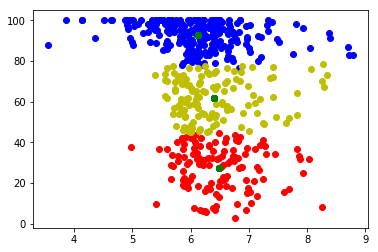

In [7]:
#gráfico dos clusters e seus respectivos centros 
#(no exemplo estou supondo q existem 3 clusters e pegando somente os atributos RM e AGE)
for i in range(len(novos_centros)):
    for j in range(len(tabela_clusters[i])):
        if(i == 0):
            plt.plot(dados_originais[tabela_clusters[i][j]][2], dados_originais[tabela_clusters[i][j]][3], 'ro')
        elif(i == 1):
            plt.plot(dados_originais[tabela_clusters[i][j]][2], dados_originais[tabela_clusters[i][j]][3], 'bo')
        elif(i == 2):
            plt.plot(dados_originais[tabela_clusters[i][j]][2], dados_originais[tabela_clusters[i][j]][3], 'yo')

        plt.plot(novos_centros[i][0], novos_centros[i][1], 'go')

plt.show()



**Conclusão:** <br/>
Apesar de não ter uma métrica para avaliar se os resultados foram bons, a olho nú é possível perceber que, apesar dos pontos de alguns dos clusters estarem um pouco distantes do seu grupo, os pontos definidos como centros (em verde), está em uma região considerada central para o seu cluster. <br/><br/>
**Referências:** <br/>
http://www.diegonogare.net/2015/08/entendendo-como-funciona-o-algoritmo-de-cluster-k-means/ <br/>
https://github.com/ExcViral/K-Means-Clustering/blob/master/k-means.py